<a href="https://colab.research.google.com/github/bkokalari/Doctoranytime-User-reviews-moderation-with-deep-learning/blob/main/Greek/Greek_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!python -m spacy download el # greek lang
!python -m spacy download el_core_news_sm
!pip install greek-stemmer
!pip install lime

     |████████████████████████████████| 11.4MB 529kB/s 
  Created wheel for el-core-news-sm: filename=el_core_news_sm-2.2.5-cp36-none-any.whl size=11422788 sha256=ad1f2e8afc59576d0b673eda6799502ddbdada68200b599e2f9455245e431bc2
  Stored in directory: /tmp/pip-ephem-wheel-cache-bmf136e1/wheels/70/a1/c5/6690d6b524d87e287a8070cf957f834fb1b1665b9ede11348b
Successfully built el-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/el_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/el
You can now load the model via spacy.load('el')
✔ Download and installation successful
You can now load the model via spacy.load('el_core_news_sm')
  Created wheel for greek-stemmer: filename=greek_stemmer-0.1.1-cp36-none-any.whl size=6738 sha256=abbd301aa0c35be9d4353cf5e857f7e3bb544714d47b34e624d0f0f064cda95d
  Stored in directory: /root/.cache/pip/wheels/b9/e5/39/735c9926a0

In [ ]:
#!pip install transformers

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import spacy
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import nltk
from spacy.lang.el.stop_words import STOP_WORDS
import itertools   
from spacy.lang.el import Greek
import string
import el_core_news_sm
import imblearn
from collections import Counter
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from scipy import stats
from greek_stemmer import GreekStemmer
import tensorflow as tf
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
revs_preprocessed = pd.read_csv("/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/preprocessed_Greek.csv") 
revs_preprocessed.sample(5)
revs_preprocessed = revs_preprocessed.dropna()
revs_preprocessed['review'] = revs_preprocessed['review'].astype(str)
revs_preprocessed = revs_preprocessed.sample(frac=1)
revs_preprocessed

,review,approved
40181,σας ευχαριστουμε,1
85176,ικανοποιημενη,1
105725,ακομη φορα εξαιρετικη ευχαριστω πολυ,1
32951,βλεπει σφαιρικα ασθενη ως ανθρωπο οχι μεμονωμε...,1
47068,κα ραπτη συνδυαζει επιστημονα ανθρωπο,1
...,...,...
80602,εμεινα ικανοποιημενος,1
112366,πολυ καλος γιατρος ευγενεστατος ανθρωπος,1
67271,αυτη φορα πηγα γιο σφραγισμα όλα καλα παντα αλ...,1
27548,έμεινα πολυ ευχαριστημενη,1


In [ ]:
revs_preprocessed.approved.value_counts()

1    120360
0      7052
Name: approved, dtype: int64

If we use stemming

In [ ]:
stemmer = GreekStemmer()

def stemming(text):
    text = [stemmer.stem(word.upper()) for word in text.split()]

    return " ".join(text)

#revs_preprocessed["review"] = revs_preprocessed["review"].map(stemming)
#revs_preprocessed["review"] = revs_preprocessed.review.str.lower()

## Split Dataset

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# splitting in train-validation-test sets in a stratified manner.
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
# sss: stratified shuffle split

# We will use this object to split the raw dataset in Train - Test in a stratified manner.

test_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=0)

test_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.15,
            train_size=None)

In [ ]:
# We will use this object to split the Train dataset in Train and Validation in a stratified manner.

val_sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
val_sss

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.2,
            train_size=None)

In [ ]:
reviews = revs_preprocessed.review
approval = revs_preprocessed.approved

In [ ]:
# splitting in train-val and test

X_train_val, X_test, y_train_val, y_test = None, None, None, None

# getting the indexes for each dataset
for train_index, test_index in test_sss.split(reviews, approval):
    
    print("TRAIN-VAL:", train_index[:10], "TEST:", test_index[:10])
    
    X_train_val, X_test = reviews.iloc[train_index], reviews.iloc[test_index]
    y_train_val, y_test = approval.iloc[train_index], approval.iloc[test_index]

TRAIN-VAL: [ 82570  40229  40081  91783  31578 126702  71891 125847  42790  91714] TEST: [ 48392  94748 114273  40282 101576  36907  29033   7109  21262  44358]
TRAIN-VAL: [73266 58071 59430 27138 94861 10525 67350 17172 84477 20071] TEST: [ 32769  97818  13939  30154  69306  88520  17768  68984  83238 116508]
TRAIN-VAL: [125389  86137  78703 110381  76800  81490 116130  39389  37438      6] TEST: [118420   7757 118736  36135  46928  25791  20654  55477  63886  69739]
TRAIN-VAL: [ 49107 121078  70128 107776  84536 104144 125518 112483  52005  53710] TEST: [68143 60870 11782 11735 31958 47328 81705 28948 15808 58464]
TRAIN-VAL: [ 16663  52607  91408   8933  82678  51619  35275 109699  31269  78801] TEST: [ 4749 20552 66389 64290 49298  1415  4589 70165 73268  5818]


In [ ]:
X_train_val.head()

81787    εκανε ερωτησεις ιστορικο εξεταση προσοχη κρατο...
20817                            ευγενεστατη επαγγελματιας
88973    προτεινα πολυ ανετα καποιον επισκεφτεικοινωνικ...
9403     εξαιρετικος συνεπης εξετασε περιπτωση ενδελεχω...
59325                                   εξαιρετικη γιατρος
Name: review, dtype: object

In [ ]:
X_train_val.shape, X_train_val.dropna().shape

((108300,), (108300,))

In [ ]:
y_train_val.shape, y_train_val.dropna().shape

((108300,), (108300,))

In [ ]:
# We reset the indexes for bot the X-train-val and y-train-val in order to break them 
# again into two subsets.
X_train_val = X_train_val.reset_index(drop=True)
y_train_val = y_train_val.reset_index(drop=True)

In [ ]:
# splitting the train-val dataset into train and validation dataset

X_train, X_val, y_train, y_val = None, None, None, None

for train_index, val_index in val_sss.split(X_train_val, y_train_val):
    
    print("TRAIN:", train_index[:10], "VALID:", test_index[:10])
    
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

TRAIN: [ 81938  30988  34406  10973    636  59632  66476  95354  92178 102431] VALID: [ 4749 20552 66389 64290 49298  1415  4589 70165 73268  5818]
TRAIN: [ 30014 103652 107119  27713  19994   4881  44402  66722  24989  57429] VALID: [ 4749 20552 66389 64290 49298  1415  4589 70165 73268  5818]
TRAIN: [ 52654  36708  80607   8442 108034 107195  25843  18606  61439  61519] VALID: [ 4749 20552 66389 64290 49298  1415  4589 70165 73268  5818]
TRAIN: [19772 47443 70624 27828 95105 74593 97998 32485 34874 47525] VALID: [ 4749 20552 66389 64290 49298  1415  4589 70165 73268  5818]
TRAIN: [13985 25928 41869 53268 15336 63983 39082 57268 32744 22757] VALID: [ 4749 20552 66389 64290 49298  1415  4589 70165 73268  5818]


In [ ]:
print('X_train_val shape: {}'.format(X_train_val.shape))
print('y_train_val shape: {}'.format(y_train_val.shape))
print()

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print()

print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

print()
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train_val shape: (108300,)
y_train_val shape: (108300,)

X_train shape: (86640,)
y_train shape: (86640,)

X_val shape: (21660,)
y_val shape: (21660,)

X_test shape: (19112,)
y_test shape: (19112,)


### Labels One-hot Encoding (not included)

In [ ]:
# Encoding the labels using a One-Hot Encoder
y_enc = OneHotEncoder(sparse=False)

In [ ]:
#y_enc.fit_transform(y_train.values.reshape(-1,1))

In [ ]:
# At first we run fit_transform on the Training data
y_train_enc = y_enc.fit_transform(y_train.values.reshape(-1, 1))
y_train_enc

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
y_train_final =  np.asarray(y_train)
y_train_final

array([0, 1, 1, ..., 1, 1, 1])

In [ ]:
y_val_final = np.asarray(y_val)
y_test_final = np.asarray(y_test)

In [ ]:
# Then we use the fitted One-hot-Encoder to transform the rest of the data
y_val_enc = y_enc.transform(y_val.values.reshape(-1, 1))

y_test_enc = y_enc.transform(y_test.values.reshape(-1, 1))

In [ ]:
print('y_train shape: {}'.format(y_train_enc.shape))
print('y_val shape: {}'.format(y_val_enc.shape))
print('y_test shape: {}'.format(y_test_enc.shape))

y_train shape: (86640, 2)
y_val shape: (21660, 2)
y_test shape: (19112, 2)


In [ ]:
#temp.sum(axis=0).head(10)

In [ ]:
#temp.sum(axis=1).sample(10)

In [ ]:
# deleting the variable (just for demonstration purposes)
#del temp

do we need the target variable one-hot encoded?

## Tokenization

In [ ]:
# Load Greek tokenizer, tagger, parser, NER and word vectors
parser = Greek()

def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

## Handling Text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
# A pandas Series is also an iterable. So we can handle it like a List.
# Concatenating all reviews into one text.
corpora = " ".join(reviews)

print(corpora[:1000])

σας ευχαριστουμε ικανοποιημενη ακομη φορα εξαιρετικη ευχαριστω πολυ βλεπει σφαιρικα ασθενη ως ανθρωπο οχι μεμονωμενα ως συμπτωματα πολυ καταρτισμενος συγκεκριμενος πρεπει πραξω βρω λυση προβλημα κα ραπτη συνδυαζει επιστημονα ανθρωπο καλη γιατροςμου βρηκε αμεσως θεραπεια προβλημα μελετησε εις βαθος περιπτωση πολυ καλος πραγματα πολυ διαφορετικα αυτο ειπε δεν εγινε σωστη παραπομπη αλλα μονο οδηγια ενος πανακριβου επιθεματος έμεινα πολυ ευχαριστημενη ενεπνευσε εμπιστοσυνη ξαναπαω συστηνω ανεπιφυλακτα πολυ καλη επιστημονας κατι σπανιζει μερες μαςανθρωπος πανω ολα πολυ ενημερωμενος προσεκτικος προσιτος ηρεμος ευγενικος συστηνω ανεπιφυλακτα άριστη υπεροχη γιατρος ανθρωπος δεν περιμενα ουτε 1’’ μπηκα ακριβως ωρα καλυψε ολα γιατρος καταρτισμενη εμπνεει εμπιστοσυνη καταρτισμενος διαθεση εξηγησει αναλυτικα παντα εξαιρετικα προσιτος πληρως κατατοπιστικος επηξηγηματικος ελαχιστους γιατρους σημειωνουν καποια βασικα στοιχεια ωρα περιγραφεις ιστορικο εμπνεει εμπιστοσυνη πληρως καταρτισμενος ενημερωμε

In [ ]:
top_words = Counter(corpora.split()).most_common()
top_words[:20]

[('πολυ', 59352),
 ('γιατρος', 31458),
 ('ανεπιφυλακτα', 15773),
 ('καλος', 14319),
 ('δεν', 13315),
 ('εμπιστοσυνη', 12472),
 ('εξαιρετικος', 11748),
 ('προβλημα', 10447),
 ('ραντεβου', 10392),
 ('καλη', 9445),
 ('ανθρωπος', 8797),
 ('ολα', 8356),
 ('συστηνω', 8107),
 ('περιπτωση', 7216),
 ('εξαιρετικη', 7194),
 ('κ', 6784),
 ('ευγενικος', 6478),
 ('επαγγελματιας', 6386),
 ('προσιτος', 6261),
 ('γιατρο', 6098)]

In [ ]:
# Total Number of Words to use for vectorization. 
# The vectorizer will keep the K most common tokens (words-characters)
max_words = 3000

'''stop_words = [
    'αν', 'απ', 'απο', 'ας', 'για', 'γιατι', 'εγω', 'ειναι', 'ενα',
    'εσυ', 'ετσι', 'εχει', 'η', 'ηταν', 'θα', 'και', 'και', 'κι', 'κ', 'μα', 'μας',
    'με', 'μες', 'μη', 'μην', 'μια', 'μου', 'μου', 'μου,', 'μ’', 'ν', 'να', 'ο',
    'οι', 'ομως', 'οπως', 'οταν', 'οτι', 'πια', 'πιο', 'που', 'πως', 'πως', 'σ',
    'σαν', 'σε', 'σου', 'σου', 'σου', 'στα', 'στη', 'στην', 'στις', 'στο', 'στον',
    'τ', 'τα', 'τη', 'την', 'της', 'τι', 'τις', 'το', 'τον', 'του', 'τους', 'των'
]'''

punctuations = string.punctuation
punctuations = punctuations.replace('@', '') # remove @ for emails

### Bag of Words Approach (BoW)


In [ ]:
# This vectorizer will give the number of appearances of each word
counter_vectorizer = CountVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    tokenizer=spacy_tokenizer,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    binary=True, # binary output or full counts. 
)
counter_vectorizer

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7fad5239f1e0>,
                vocabulary=None)

Fitting the CountVectorizer **ONLY ON THE TRAINING DATASET**

In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_bow = counter_vectorizer.fit_transform(X_train)

In [ ]:
# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_bow = counter_vectorizer.transform(X_val)
X_test_enc_bow = counter_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_bow.shape))
print('X_val encoded shape: {}'.format(X_val_enc_bow.shape))
print('X_test encoded shape: {}'.format(X_test_enc_bow.shape))

X_train encoded shape: (86640, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
X_train_enc_bow[0].todense()

matrix([[0, 0, 0, ..., 0, 0, 0]])

### Tf-idf vectorizer Approach

In [ ]:
# This vectorizer will give the number of appearances of each word
tfidf_vectorizer = TfidfVectorizer(
    encoding='utf-8',
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    tokenizer=spacy_tokenizer,
    ngram_range=(1, 1), # unigrams
    max_features=max_words,
    #binary=False, # binary output or full counts. 
)
counter_vectorizer

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=3000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function spacy_tokenizer at 0x7fad5239f1e0>,
                vocabulary=None)

In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_tfidf = tfidf_vectorizer.transform(X_val)
X_test_enc_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_tfidf.shape))
print('X_val encoded shape: {}'.format(X_val_enc_tfidf.shape))
print('X_test encoded shape: {}'.format(X_test_enc_tfidf.shape))

X_train encoded shape: (86640, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
X_train_enc_tfidf[0].todense()

matrix([[0., 0., 0., ..., 0., 0., 0.]])

Vectorized Representation

In [ ]:
X_counts = X_train_enc_bow
X_tfidf = X_train_enc_tfidf
y = y_train

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ["orange", "blue", "blue"]
    if plot:
        plt.scatter(
            lsa_scores[:, 0],
            lsa_scores[:, 1],
            s=8,
            alpha=0.8,
            c=test_labels,
            cmap=matplotlib.colors.ListedColormap(colors),
        )
        red_patch = mpatches.Patch(color="orange", label="Not Approved")
        green_patch = mpatches.Patch(color="blue", label="Approved")
        plt.legend(handles=[red_patch, green_patch], prop={"size": 16})


### Comparison

Visualization of vectorized text represantation in order to choose the best one

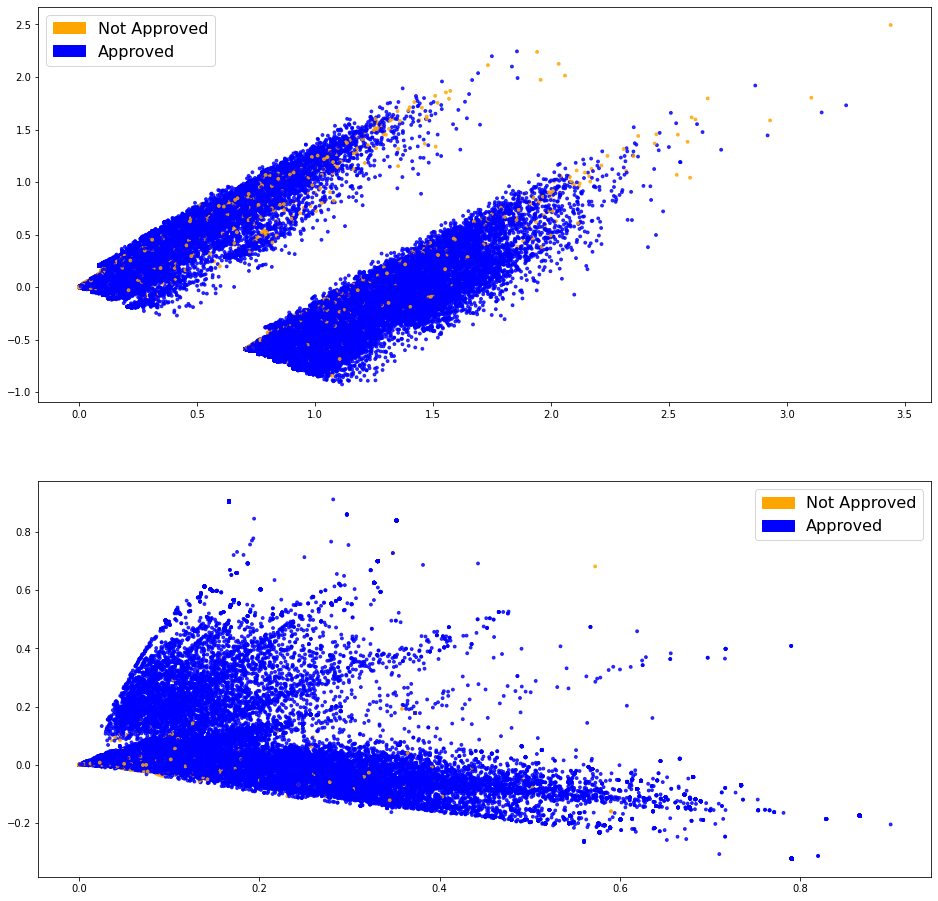

In [ ]:
plt.figure(1, figsize=(16, 16))
plt.subplot(2, 1, 1)
plot_LSA(X_counts, y)
plt.subplot(2, 1, 2)
plot_LSA(X_tfidf, y)

# Modeling

## Feed-Forward model

### With Imbalanced dataset

In [ ]:
# !pip install pydot
# !pip install graphviz
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
import pydot

In [ ]:
# Some parameters that we will use:

# Number of Classes for the Y labels
nb_classes = len(y_train.value_counts())

print('Number of Classes: {}'.format(nb_classes))

# Number of Epochs that we will train our Feed Forward Network
nb_epoch = 20

# The batch_size of the data that  will be fed to the Model when training
batch_size = 32 

# Dropout Rate of the Dropout Layer (how many neurons to shutdown each time)
dropout_rate = 0.4

Number of Classes: 2


Model Setup

In [ ]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model = Sequential()

# add a dense layer (MLP)
model.add(Dense(512, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 40% of inputs dropped
model.add(Dropout(dropout_rate))

# add a dense layer (MLP)
model.add(Dense(512))

# use a relu activation on MLP's outputs
model.add(Activation('relu'))

# use a dropout layer with with 20% of inputs droped
model.add(Dropout(dropout_rate))

# add a dense layer (MLP) 
model.add(Dense(1)) # if we want to change the one-hot, set dense 1

# use a softmax activation on 2nd MLP's outputs
model.add(Activation('sigmoid'))

# we have defined the structure of the model

# print model layers' info
print(model.summary())

Building model...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               1536512   
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1

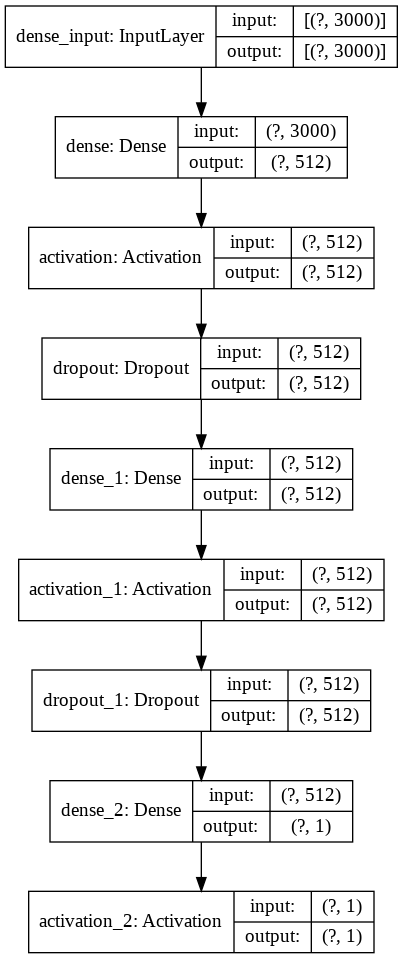

In [ ]:
plot_model(model,
           to_file='model_plot.png',
           show_shapes=True,
           show_layer_names=True)

In [ ]:
# We compile the model using categorical crossentropy as a loss function 
# The reason is that we want to predict the lyricist among many lyricists

# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy'],
)
# we have compiled a model and it is ready to be trained

In [ ]:
X_train_enc_bow

<86640x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 703309 stored elements in Compressed Sparse Row format>

In [ ]:
y_train.shape

(86640,)

In [ ]:
X_val_enc_bow

<21660x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 173664 stored elements in Compressed Sparse Row format>

In [ ]:
y_val.shape

(21660,)

#### Fitting (training) our Feed Forward Network Model

In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=False)                         

In [ ]:
# We train (fit our data to) our model
history = model.fit(
    x=X_train_enc_bow.todense(),           # features (as dense inputs)
    y=y_train,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    callbacks=early_stop,
    validation_data=(       
    X_val_enc_bow.todense(),               # the validation split that we did before
    y_val)
)

Epoch 1/20
2708/2708 - 13s - loss: 0.1107 - binary_accuracy: 0.9616 - val_loss: 0.0951 - val_binary_accuracy: 0.9654
Epoch 2/20
2708/2708 - 13s - loss: 0.0739 - binary_accuracy: 0.9727 - val_loss: 0.1002 - val_binary_accuracy: 0.9660
Epoch 3/20
2708/2708 - 13s - loss: 0.0492 - binary_accuracy: 0.9811 - val_loss: 0.1094 - val_binary_accuracy: 0.9672
Epoch 4/20
2708/2708 - 13s - loss: 0.0349 - binary_accuracy: 0.9866 - val_loss: 0.1304 - val_binary_accuracy: 0.9672
Epoch 5/20
2708/2708 - 13s - loss: 0.0285 - binary_accuracy: 0.9893 - val_loss: 0.1628 - val_binary_accuracy: 0.9668
Epoch 6/20
2708/2708 - 13s - loss: 0.0260 - binary_accuracy: 0.9897 - val_loss: 0.1540 - val_binary_accuracy: 0.9663
Epoch 00006: early stopping


In [ ]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

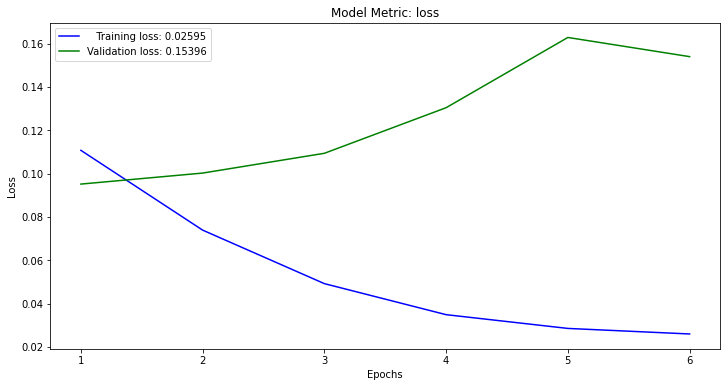

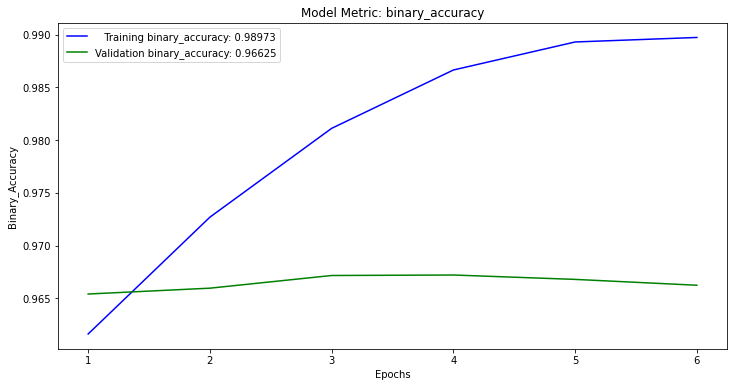

In [ ]:
plot_keras_history(history)

#### Model Evaluation

In [ ]:
# evaluate and store on score variable on the TEST DATASET
score = model.evaluate(
    X_test_enc_bow.todense(),    # features
    y_test,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

598/598 - 2s - loss: 0.1299 - binary_accuracy: 0.9700


In [ ]:
print('\nTest binary_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.12994486093521118

Test accuracy: 96.997 %


#### Model Prediction 

In [ ]:
#model_feed = model

In [ ]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model.predict(X_test_enc_bow)
y_test_pred_probs

array([[0.99823594],
       [0.9991423 ],
       [1.        ],
       ...,
       [0.9999982 ],
       [0.56584483],
       [1.        ]], dtype=float32)

In [ ]:
y_test_preds = tf.greater(y_test_pred_probs, .5)
predicted_feed = y_test_preds

In [ ]:
# Use to yield the predicted classes.
# Depicts which class (number) is 

# y_test_preds = model.predict_classes(X_test_enc)

#y_test_preds = np.argmax(model.predict(X_test_enc_bow), axis=-1)

#y_test_preds

In [ ]:
'''# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)'''

'# custom prediction function \ndef get_one_hot_predictions(pred_probs):\n    """\n    """\n    max_probs = np.max(pred_probs, axis=1)\n    \n    # reshaping to (len_of_predicts, 1)\n    max_probs = max_probs.reshape(max_probs.shape[0], 1)\n\n    return np.equal(pred_probs, max_probs).astype(float)'

In [ ]:
#y_test_pred = get_one_hot_predictions(y_test_pred_probs)
#y_test_pred

# check that each line has only one 1. 
# y_test_pred.sum(axis=1)

In [ ]:
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
#y_test_pred_approval = y_enc.inverse_transform(y_test_pred).flatten()
#y_test_pred_approval[:20]

In [ ]:
# More Evaluation Metrics
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_preds)
conf_mat

array([[  772,   286],
       [  288, 17766]])

In [ ]:
# a bit prettier
#pd.DataFrame(conf_mat,
#             columns = ["0","1"],
#             index=y_enc.categories_)

In [ ]:
revs_preprocessed.approved.unique()

array([1, 0])

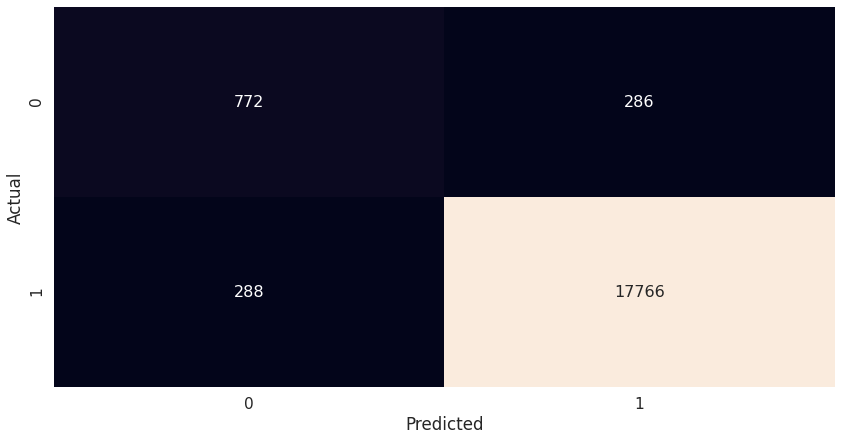

In [ ]:
array_final = conf_mat
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_preds))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1058
           1       0.98      0.98      0.98     18054

    accuracy                           0.97     19112
   macro avg       0.86      0.86      0.86     19112
weighted avg       0.97      0.97      0.97     19112



In [ ]:
def Approval(prob):
  if prob >= 0.5:
    return 1
  else:
    return 0

In [ ]:
# Predicting a single review

input_rev = """
ο γιατρος ηταν απαραδεκτος
"""

# vectorizing Song with Count Vectorizer
rev_vect = counter_vectorizer.transform([input_rev])

print(rev_vect.shape, end='\n\n')

rev_pred = model.predict(rev_vect)

print('Probabilities', end='\n\n')
print(rev_pred, end='\n\n')

#rev_pred_hot = get_one_hot_predictions(rev_pred)

#print('Probabilities One Hot Vector', end='\n\n')
#print(rev_pred_hot, end='\n\n')

print('Approval Prediction:', end='\n\n')
print(Approval(rev_pred))

(1, 3000)

Probabilities

[[0.00895056]]

Approval Prediction:

0


### Oversampling

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

#num_words = len(counter)

#max_length = 100 # mean is 800
#random_reviews = reviews.sample(frac=1)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
not_appr_upsampled = resample(not_approved,
                          replace=True, # sample with replacement
                          n_samples=len(approved)//4, # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([approved, not_appr_upsampled])

# check new class counts
print(upsampled.approved.value_counts())
upsampled = upsampled.sample(frac=1)

1    81845
0    20461
Name: approved, dtype: int64


In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_bow_up = counter_vectorizer.fit_transform(upsampled.review)

# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_bow_up = counter_vectorizer.transform(X_val)
X_test_enc_bow_up = counter_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_bow_up.shape))
print('X_val encoded shape: {}'.format(X_val_enc_bow_up.shape))
print('X_test encoded shape: {}'.format(X_test_enc_bow_up.shape))

X_train encoded shape: (102306, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
#y_train_enc = y_enc.fit_transform(upsampled.approved.values.reshape(-1, 1))
#y_train_enc

In [ ]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model_over = Sequential()

# add a dense layer (MLP)
model_over.add(Dense(512, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model_over.add(Activation('relu'))

# use a dropout layer with with 40% of inputs dropped
model_over.add(Dropout(dropout_rate))

# add a dense layer (MLP)
model_over.add(Dense(512))

# use a relu activation on MLP's outputs
model_over.add(Activation('relu'))

# use a dropout layer with with 20% of inputs droped
model_over.add(Dropout(dropout_rate))

# add a dense layer (MLP) 
model_over.add(Dense(1)) # if we want to change the one-hot, set dense 1

# use a sigmoid activation
model_over.add(Activation('sigmoid'))

# we have defined the structure of the model

# print model layers' info
print(model_over.summary())

Building model...

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               1536512   
_________________________________________________________________
activation_3 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None,

In [ ]:
# We compile the model using categorical crossentropy as a loss function 
# The reason is that we want to predict the lyricist among many lyricists

# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model_over.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy'],
)
# we have compiled a model and it is ready to be trained

#### Fitting (training) our Feed Forward Network Model

In [ ]:
# We train (fit our data to) our model
history_over = model_over.fit(
    x=X_train_enc_bow_up.todense(),           # features (as dense inputs)
    y=upsampled.approved,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    callbacks=early_stop,
    validation_data=(       
    X_val_enc_bow_up.todense(),               # the validation split that we did before
    y_val)
)

Epoch 1/20
3198/3198 - 15s - loss: 0.1516 - binary_accuracy: 0.9469 - val_loss: 0.1026 - val_binary_accuracy: 0.9644
Epoch 2/20
3198/3198 - 15s - loss: 0.0693 - binary_accuracy: 0.9762 - val_loss: 0.1372 - val_binary_accuracy: 0.9652
Epoch 3/20
3198/3198 - 15s - loss: 0.0467 - binary_accuracy: 0.9842 - val_loss: 0.1644 - val_binary_accuracy: 0.9655
Epoch 4/20
3198/3198 - 15s - loss: 0.0402 - binary_accuracy: 0.9863 - val_loss: 0.1521 - val_binary_accuracy: 0.9646
Epoch 5/20
3198/3198 - 15s - loss: 0.0385 - binary_accuracy: 0.9869 - val_loss: 0.1851 - val_binary_accuracy: 0.9661
Epoch 6/20
3198/3198 - 15s - loss: 0.0365 - binary_accuracy: 0.9876 - val_loss: 0.1983 - val_binary_accuracy: 0.9655
Epoch 00006: early stopping


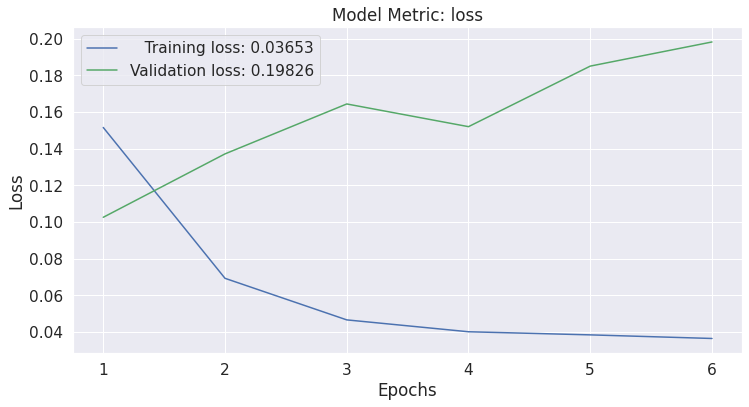

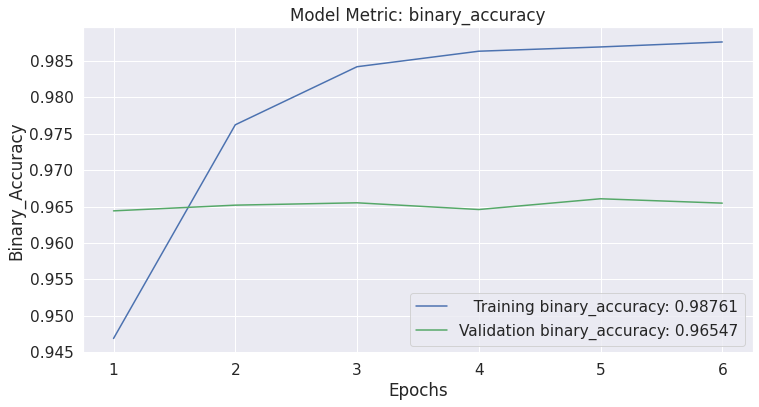

In [ ]:
plot_keras_history(history_over)

#### Model Evaluation

In [ ]:
# evaluate and store on score variable on the TEST DATASET
score = model_over.evaluate(
    X_val_enc_bow_up.todense(),    # features
    y_val,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

677/677 - 2s - loss: 0.1983 - binary_accuracy: 0.9655


In [ ]:
print('\nTest binary_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.19825956225395203

Test accuracy: 96.547 %


#### Model Prediction

In [ ]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model_over.predict(X_test_enc_bow_up)
y_test_pred_probs

array([[0.9996892 ],
       [0.99936074],
       [1.        ],
       ...,
       [1.        ],
       [0.6788113 ],
       [1.        ]], dtype=float32)

In [ ]:
y_test_preds = tf.greater(y_test_pred_probs, .5)

In [ ]:
# Use to yield the predicted classes.
# Depicts which class (number) is 

# y_test_preds = model.predict_classes(X_test_enc)

#y_test_preds = np.argmax(model.predict(X_test_enc_bow), axis=-1)

#y_test_preds[:50]

In [ ]:
'''# custom prediction function 
def get_one_hot_predictions(pred_probs):
    """
    """
    max_probs = np.max(pred_probs, axis=1)
    
    # reshaping to (len_of_predicts, 1)
    max_probs = max_probs.reshape(max_probs.shape[0], 1)

    return np.equal(pred_probs, max_probs).astype(float)'''

'# custom prediction function \ndef get_one_hot_predictions(pred_probs):\n    """\n    """\n    max_probs = np.max(pred_probs, axis=1)\n    \n    # reshaping to (len_of_predicts, 1)\n    max_probs = max_probs.reshape(max_probs.shape[0], 1)\n\n    return np.equal(pred_probs, max_probs).astype(float)'

In [ ]:
#y_test_pred = get_one_hot_predictions(y_test_pred_probs)
#y_test_pred

# check that each line has only one 1. 
# y_test_pred.sum(axis=1)

In [ ]:
# Now, we will use the fitted One Hot Encoder to Inverse Tranform the ouput
#y_test_pred_approval = y_enc.inverse_transform(y_test_pred).flatten()
#y_test_pred_approval[:20]

In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_preds)
conf_mat

array([[  727,   331],
       [  264, 17790]])

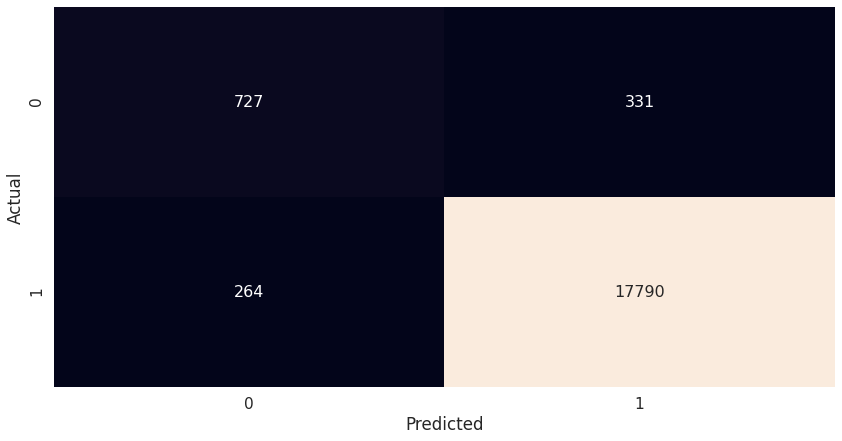

In [ ]:
array_final = conf_mat
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_preds))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1058
           1       0.98      0.99      0.98     18054

    accuracy                           0.97     19112
   macro avg       0.86      0.84      0.85     19112
weighted avg       0.97      0.97      0.97     19112



### Undersampling

In [ ]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
appr_downsampled = resample(approved,
                          replace=True, # sample with replacement
                          n_samples=25000, # match number in majority class
                          random_state=27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_approved, appr_downsampled])

# check new class counts
print(downsampled.approved.value_counts())
downsampled = downsampled.sample(frac=1) #shuffle

1    25000
0     4795
Name: approved, dtype: int64


In [ ]:
# fitting the CountVectorizer in the training data
X_train_enc_bow_down = counter_vectorizer.fit_transform(downsampled.review)

# Using the FITTED CountVectorizer we transform the Validation and Test Sets
X_val_enc_bow_down = counter_vectorizer.transform(X_val)
X_test_enc_bow_down = counter_vectorizer.transform(X_test)

In [ ]:
print('X_train encoded shape: {}'.format(X_train_enc_bow_down.shape))
print('X_val encoded shape: {}'.format(X_val_enc_bow_down.shape))
print('X_test encoded shape: {}'.format(X_test_enc_bow_down.shape))

X_train encoded shape: (29795, 3000)
X_val encoded shape: (21660, 3000)
X_test encoded shape: (19112, 3000)


In [ ]:
print('Building model...', end='\n\n')

# The model that we will create is a sequential model meaning that
# each layer that we add per line will use as input the output of the 
# former layer added to the model

# define an empty sequential structure 
model_under = Sequential()

# add a dense layer (MLP)
model_under.add(Dense(256, input_shape=(max_words,)))

# use a relu activation on MLP's outputs
model_under.add(Activation('relu'))

# use a dropout layer with with 40% of inputs dropped
model_under.add(Dropout(dropout_rate))

# add a dense layer (MLP)
model_under.add(Dense(512))

# use a relu activation on MLP's outputs
model_under.add(Activation('relu'))

# use a dropout layer with with 20% of inputs droped
model_under.add(Dropout(dropout_rate))

# add a dense layer (MLP) 
model_under.add(Dense(1)) # if we want to change the one-hot, set dense 1

# use a sigmoid activation
model_under.add(Activation('sigmoid'))

# we have defined the structure of the model

# print model layers' info
print(model_under.summary())

Building model...

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               768256    
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
activation_7 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None,

In [ ]:
# We compile the model using categorical crossentropy as a loss function 
# The reason is that we want to predict the lyricist among many lyricists

# and Adam as an optimizer (is more robust thatn Gradient Descent Optimizer)
# As a metric we can use "accuracy"
model_under.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['binary_accuracy'],
)
# we have compiled a model and it is ready to be trained

#### Fitting (training) our Feed Forward Network Model

In [ ]:
# We train (fit our data to) our model
history_under = model_under.fit(
    x=X_train_enc_bow_down.todense(),           # features (as dense inputs)
    y=downsampled.approved,           # labels
    batch_size=batch_size,   # define batch size
    epochs=nb_epoch,         # number of epochs
    verbose=2,               # the most extended verbosity level
    callbacks=early_stop,
    validation_data=(       
    X_val_enc_bow_down.todense(),               # the validation split that we did before
    y_val)
)

Epoch 1/20
932/932 - 6s - loss: 0.2112 - binary_accuracy: 0.9232 - val_loss: 0.1188 - val_binary_accuracy: 0.9579
Epoch 2/20
932/932 - 6s - loss: 0.1330 - binary_accuracy: 0.9545 - val_loss: 0.1236 - val_binary_accuracy: 0.9587
Epoch 3/20
932/932 - 5s - loss: 0.0930 - binary_accuracy: 0.9691 - val_loss: 0.1428 - val_binary_accuracy: 0.9572
Epoch 4/20
932/932 - 5s - loss: 0.0683 - binary_accuracy: 0.9775 - val_loss: 0.1756 - val_binary_accuracy: 0.9570
Epoch 5/20
932/932 - 5s - loss: 0.0539 - binary_accuracy: 0.9818 - val_loss: 0.2131 - val_binary_accuracy: 0.9535
Epoch 6/20
932/932 - 5s - loss: 0.0472 - binary_accuracy: 0.9839 - val_loss: 0.2160 - val_binary_accuracy: 0.9581
Epoch 00006: early stopping


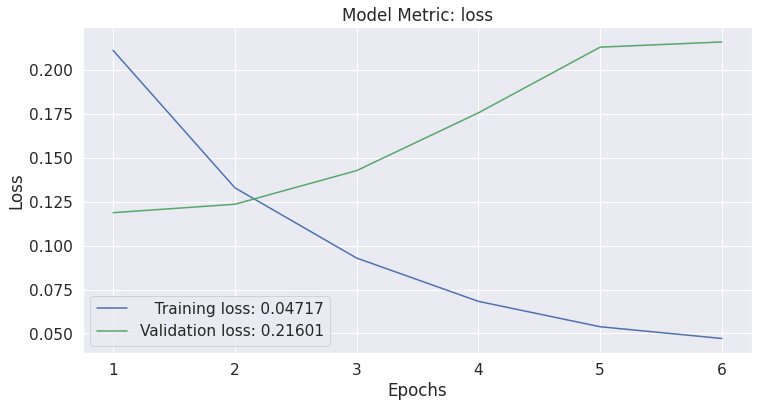

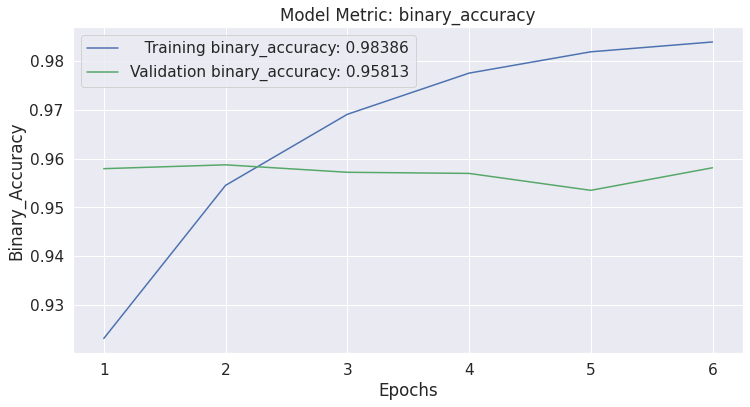

In [ ]:
plot_keras_history(history_under)

#### Model Evaluation

In [ ]:
# evaluate and store on score variable on the TEST DATASET
score = model_under.evaluate(
    X_val_enc_bow_down.todense(),    # features
    y_val,              # labels
    batch_size=batch_size,   # batch size
    verbose=2                # the most extended verbose
)

677/677 - 2s - loss: 0.2160 - binary_accuracy: 0.9581


In [ ]:
print('\nTest binary_crossentropy: {}'.format(score[0]))
print('\nTest accuracy: {:.3f} %'.format(score[1]*100))


Test binary_crossentropy: 0.21601255238056183

Test accuracy: 95.813 %


#### Model Prediction

In [ ]:
# Use to yield probability distribution over the categories
y_test_pred_probs = model_under.predict(X_test_enc_bow_down)
y_test_pred_probs

array([[0.9978211 ],
       [0.99757725],
       [1.        ],
       ...,
       [0.9999999 ],
       [0.3769692 ],
       [1.        ]], dtype=float32)

In [ ]:
y_test_preds = tf.greater(y_test_pred_probs, .5)

In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=y_test_preds)
conf_mat

array([[  864,   194],
       [  561, 17493]])

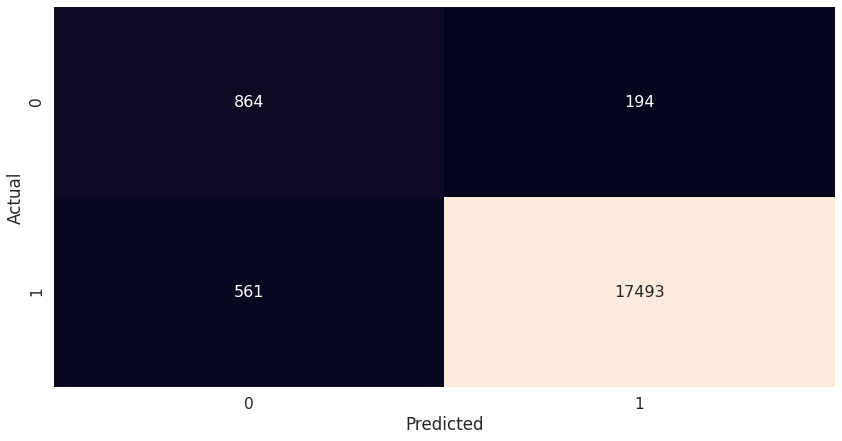

In [ ]:
array_final = conf_mat
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=y_test_preds))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70      1058
           1       0.99      0.97      0.98     18054

    accuracy                           0.96     19112
   macro avg       0.80      0.89      0.84     19112
weighted avg       0.97      0.96      0.96     19112



## LSTM model

Maybe we should not remove stopwords from LSTM to capture better the context.

### With Imbalanced dataset

In [ ]:
from collections import Counter
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
          count[word] += 1
    return count

In [ ]:
text = revs_preprocessed.review
counter = counter_word(text)
len(counter)

54129

In [ ]:
counter

Counter({'κανει': 3582,
         'νιωθεις': 1314,
         'πολυ': 59352,
         'ανετα': 4670,
         'γλυκια': 264,
         'ευγενικη': 3709,
         'πηγα': 2027,
         'γιατρο': 6098,
         'ηλικιωμενη': 17,
         'συγγενη': 28,
         'υπηρξε': 565,
         'καλη': 9445,
         'προσεγγιση': 1507,
         'επιστημονικα': 191,
         'κοινωνικα': 7,
         'γιατρος': 31458,
         'προσιτη': 3412,
         'ολα': 8356,
         'αψογα': 654,
         'ξαναεπελεγα': 7,
         'ευγενεστατος': 1173,
         'προσιτος': 6261,
         'δευτερη': 1059,
         'επισκεψη': 3821,
         'ήμουν': 100,
         'εμφανως': 28,
         'αγχωμενος': 20,
         'αλλα': 5223,
         'φευγοντας': 126,
         'ενιωθα': 106,
         'ηδη': 1117,
         'καλυτερα': 474,
         'φαινεται': 1025,
         'γνωριζει': 681,
         'αντικειμενο': 1784,
         'δεν': 13315,
         'περιττολογει': 1,
         'ευγενικος': 6478,
         'μετρο': 72,
      

In [ ]:
num_words = len(counter)

max_length = 80

Maybe we can use a different vectorizer here

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [ ]:

#pad sequences

from keras.preprocessing.sequence import  pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length,padding="post",truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_length,padding="post",truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length,padding="post",truncating="post")

In [ ]:
print(revs_preprocessed.review[0])
print(train_sequences[0])

καθησυχαστικη εμπειρη αποτελεσματικη
[34, 3067]


In [ ]:
##building the lstm model

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

lstm = Sequential()

lstm.add(Embedding(num_words, 32, input_length = max_length))
lstm.add(Bidirectional(LSTM(64, dropout=0.1, return_sequences=True)))
lstm.add(Bidirectional(LSTM(64, dropout=0.3)))
lstm.add(Dense(1,activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
lstm.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 32)            1732128   
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,880,737
Trainable params: 1,880,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=2, mode='auto', restore_best_weights=False)                         

#### Fitting (training) our LSTM Model

In [ ]:
history_lstm = lstm.fit(
 train_padded,y_train,epochs=10, validation_data=(val_padded, y_val), callbacks=early_stop
)

Epoch 1/10
2708/2708 [==============================] - 258s 95ms/step - loss: 0.1182 - accuracy: 0.9589 - val_loss: 0.0942 - val_accuracy: 0.9662
Epoch 2/10
2708/2708 [==============================] - 286s 106ms/step - loss: 0.0774 - accuracy: 0.9738 - val_loss: 0.0891 - val_accuracy: 0.9685
Epoch 3/10
2708/2708 [==============================] - 286s 106ms/step - loss: 0.0622 - accuracy: 0.9802 - val_loss: 0.0914 - val_accuracy: 0.9680
Epoch 4/10
2708/2708 [==============================] - 285s 105ms/step - loss: 0.0516 - accuracy: 0.9843 - val_loss: 0.0940 - val_accuracy: 0.9660
Epoch 5/10
2708/2708 [==============================] - 285s 105ms/step - loss: 0.0438 - accuracy: 0.9866 - val_loss: 0.1034 - val_accuracy: 0.9666
Epoch 6/10
2708/2708 [==============================] - 285s 105ms/step - loss: 0.0384 - accuracy: 0.9881 - val_loss: 0.1036 - val_accuracy: 0.9662
Epoch 7/10
2708/2708 [==============================] - 282s 104ms/step - loss: 0.0354 - accuracy: 0.9890 - val_l

In [ ]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

#### Model Evaluation

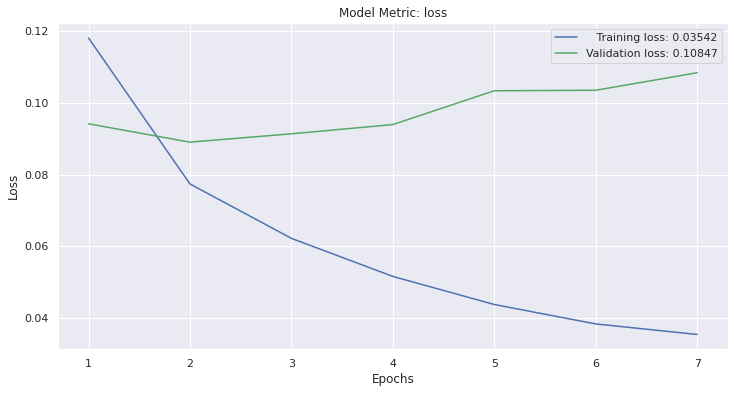

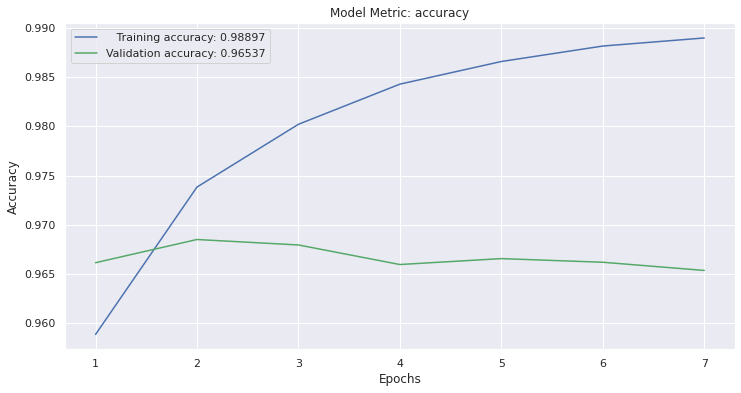

In [ ]:
sns.set()
plot_keras_history(history_lstm)

#### Model Prediction

In [ ]:
predicted_lstm = lstm.predict(test_padded) #change val and test
predicted_lstm = tf.greater(predicted_lstm, .5)

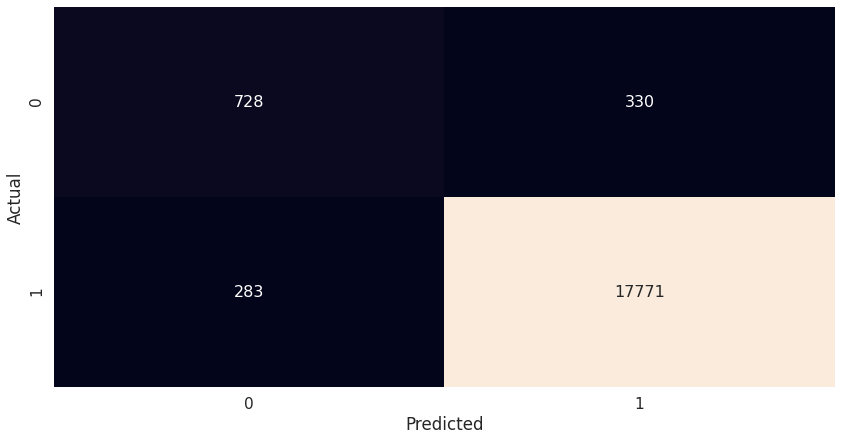

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

array_final = confusion_matrix(y_test, predicted_lstm)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Oversampling

In [ ]:
'''from sklearn.utils import resample
from sklearn.model_selection import train_test_split

num_words = len(counter)

max_length = 100 # mean is 800
#random_reviews = reviews.sample(frac=1)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
not_appr_upsampled = resample(not_approved,
                          replace=True, # sample with replacement
                          n_samples=len(approved)//4, # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([approved, not_appr_upsampled])

# check new class counts
print(upsampled.approved.value_counts())
upsampled = upsampled.sample(frac=1)'''

'from sklearn.utils import resample\nfrom sklearn.model_selection import train_test_split\n\nnum_words = len(counter)\n\nmax_length = 100 # mean is 800\n#random_reviews = reviews.sample(frac=1)\n\n# concatenate our training data back together\nX = pd.concat([X_train, y_train], axis=1)\n\n# separate minority and majority classes\nnot_approved = X[X.approved==0]\napproved = X[X.approved==1]\n\n# upsample minority\nnot_appr_upsampled = resample(not_approved,\n                          replace=True, # sample with replacement\n                          n_samples=len(approved)//4, # match number in majority class\n                          random_state=27) # reproducible results\n\n# combine majority and upsampled minority\nupsampled = pd.concat([approved, not_appr_upsampled])\n\n# check new class counts\nprint(upsampled.approved.value_counts())\nupsampled = upsampled.sample(frac=1)'

In [ ]:
train_sentences = upsampled.review
train_labels = upsampled.approved
val_sentences = X_val
val_labels = y_val
test_sentences = X_test
test_labels = y_test

In [ ]:
upsampled.review

11180     κυριος σακαδακης απλως εξαιρετικος πολυ καλος ...
27440          εξαιρετικη εξυπηρετηση ενεπνευσε εμπιστοσυνη
45343     κκωβαιος παραπανω εξαιρετικος άριστος επιστημο...
27202     γιατρος εξοργισμενος εοπυ γεγονος απληρωτος εξ...
38902            έμεινα ικανοποιημενη ήταν πολυ εξυπηρετικη
                                ...                        
81769                                           εξαιρετικος
19189     πρωτη επαφη γιατρο αποκομισα θετικες εντυπωσει...
53876     παρα πολυ καλος γιατρος συζητησαμε αρκετα δινε...
37157                              όλα πηγαν παρα πολυ καλα
104794                                          εξαιρετικος
Name: review, Length: 102306, dtype: object

In [ ]:
X_train

13985                                      χωρις παρατηρηση
25928                                  φρονω παρα πολυ καλη
41869                             πολυ ευχαριστημενη εμεινα
53268       συμβουλες γιατρου βοηθησαν αρκετα προβλημα ειχα
15336                                              ολα καλα
                                ...                        
30200      πολυ προσιτος γιατρος ασθενη κανει νιωθεις ανετα
90133     γιατρος εξαιρετικα αναλυτικος συστηματικος ζητ...
11206     εξαιρετικος επιστημονας προσιτος αναλυτικοςασχ...
99523     κα πρεβεντη συνεπης προσιτη οξυδερκης παροτι δ...
107858       πολυ ευγενικος διαθεση ψαξει αιτια προβληματος
Name: review, Length: 86640, dtype: object

In [ ]:
val_labels.value_counts()

1    20461
0     1199
Name: approved, dtype: int64

In [ ]:
test_labels.value_counts()

1    18054
0     1058
Name: approved, dtype: int64

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
#word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sentences = tokenizer.texts_to_sequences(X_val)
test_sentences = tokenizer.texts_to_sequences(X_test)

In [ ]:
#pad sequences

from keras.preprocessing.sequence import  pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length,padding="post",truncating="post")
val_padded = pad_sequences(val_sentences, maxlen=max_length,padding="post",truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length,padding="post",truncating="post")

In [ ]:
##building the lstm model

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

lstm_over = Sequential()

lstm_over.add(Embedding(num_words, 32, input_length = max_length))
#lstm_over.add(Bidirectional(LSTM(64, dropout=0.1, return_sequences=True)))
#lstm_over.add(Bidirectional(LSTM(128, dropout=0.5, return_sequences=True)))
lstm_over.add(Bidirectional(LSTM(64, dropout=0.3)))
lstm_over.add(Dense(1,activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
lstm_over.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

lstm_over.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 80, 32)            1732128   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 1,781,921
Trainable params: 1,781,921
Non-trainable params: 0
_________________________________________________________________


#### Fitting (training) our LSTM Model

In [ ]:
history_lstm_over = lstm_over.fit(
 train_padded,train_labels,epochs=10, validation_data=(val_padded, y_val), callbacks=early_stop
)

Epoch 1/10
3198/3198 [==============================] - 193s 60ms/step - loss: 0.2147 - accuracy: 0.9208 - val_loss: 0.0966 - val_accuracy: 0.9670
Epoch 2/10
3198/3198 [==============================] - 211s 66ms/step - loss: 0.1210 - accuracy: 0.9607 - val_loss: 0.0987 - val_accuracy: 0.9663
Epoch 3/10
3198/3198 [==============================] - 210s 66ms/step - loss: 0.0941 - accuracy: 0.9710 - val_loss: 0.1088 - val_accuracy: 0.9657
Epoch 4/10
3198/3198 [==============================] - 211s 66ms/step - loss: 0.0775 - accuracy: 0.9764 - val_loss: 0.1128 - val_accuracy: 0.9634
Epoch 5/10
3198/3198 [==============================] - 212s 66ms/step - loss: 0.0657 - accuracy: 0.9795 - val_loss: 0.1193 - val_accuracy: 0.9644
Epoch 6/10
3198/3198 [==============================] - 210s 66ms/step - loss: 0.0562 - accuracy: 0.9826 - val_loss: 0.1300 - val_accuracy: 0.9609
Epoch 00006: early stopping


#### Model Evaluation

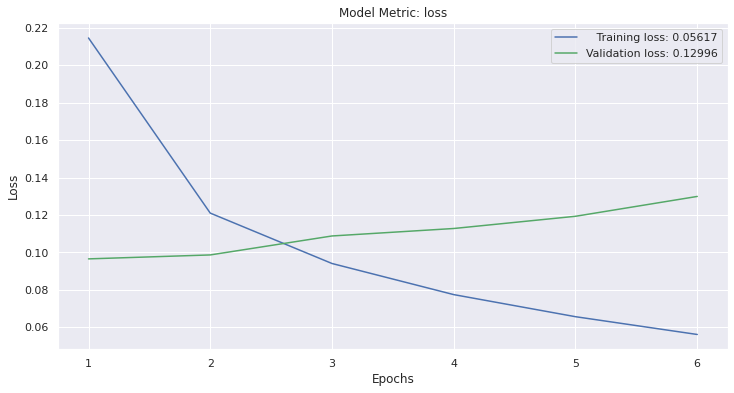

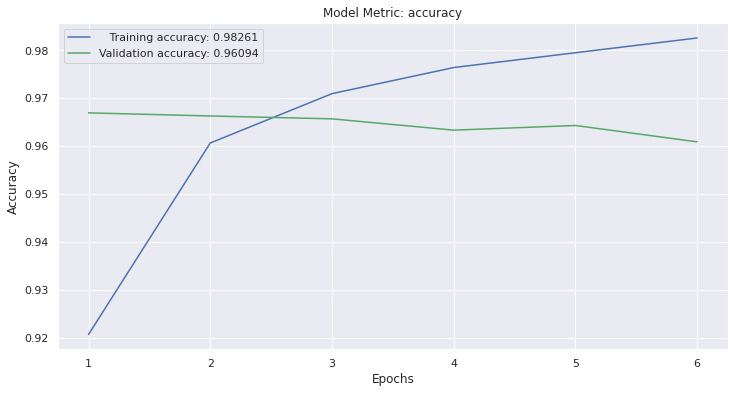

In [ ]:
sns.set()
plot_keras_history(history_lstm_over)

#### Model Prediction

In [ ]:
predicted_over = lstm_over.predict(test_padded) #change val and test
predicted_over = tf.greater(predicted_over, .5)

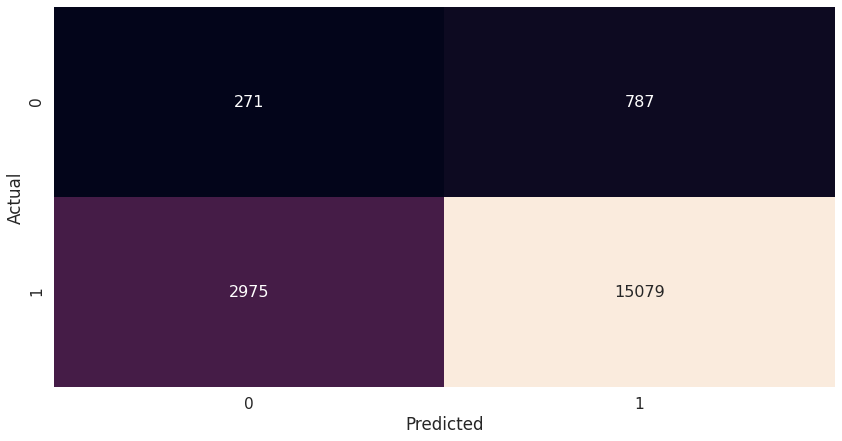

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

array_final = confusion_matrix(y_test, predicted_over)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Undersampling

In [ ]:
'''from sklearn.utils import resample
from sklearn.model_selection import train_test_split

num_words = len(counter)

max_length = 60
#random_reviews = reviews.sample(frac=1)

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_approved = X[X.approved==0]
approved = X[X.approved==1]

# upsample minority
appr_downsampled = resample(approved,
                          replace=True, # sample with replacement
                          n_samples=25000, # match number in majority class
                          random_state=27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_approved, appr_downsampled])

# check new class counts
print(downsampled.approved.value_counts())
downsampled = downsampled.sample(frac=1) #shuffle'''

'from sklearn.utils import resample\nfrom sklearn.model_selection import train_test_split\n\nnum_words = len(counter)\n\nmax_length = 60\n#random_reviews = reviews.sample(frac=1)\n\n# concatenate our training data back together\nX = pd.concat([X_train, y_train], axis=1)\n\n# separate minority and majority classes\nnot_approved = X[X.approved==0]\napproved = X[X.approved==1]\n\n# upsample minority\nappr_downsampled = resample(approved,\n                          replace=True, # sample with replacement\n                          n_samples=25000, # match number in majority class\n                          random_state=27) # reproducible results\n\n# combine minority and downsampled majority\ndownsampled = pd.concat([not_approved, appr_downsampled])\n\n# check new class counts\nprint(downsampled.approved.value_counts())\ndownsampled = downsampled.sample(frac=1) #shuffle'

In [ ]:
train_sentences = downsampled.review
train_labels = downsampled.approved
val_sentences = X_val
val_labels = y_val
test_sentences = X_test
test_labels = y_test

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
#word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
val_sentences = tokenizer.texts_to_sequences(X_val)
test_sentences = tokenizer.texts_to_sequences(X_test)

In [ ]:
#pad sequences

from keras.preprocessing.sequence import  pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length,padding="post",truncating="post")
val_padded = pad_sequences(val_sentences, maxlen=max_length,padding="post",truncating="post")
test_padded = pad_sequences(test_sequences, maxlen=max_length,padding="post",truncating="post")

In [ ]:
##building the lstm model

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense, Dropout, Bidirectional
from keras.initializers import Constant
from keras.optimizers import Adam

lstm_under = Sequential()

lstm_under.add(Embedding(num_words, 32, input_length = max_length))
lstm_under.add(Bidirectional(LSTM(64 ,dropout=0.1)))
lstm_under.add(Dense(1,activation="sigmoid"))

optimizer = Adam(learning_rate=3e-4)
lstm_under.compile(loss="binary_crossentropy", optimizer=optimizer, metrics="accuracy")

lstm_under.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 80, 32)            1732128   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               49664     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 1,781,921
Trainable params: 1,781,921
Non-trainable params: 0
_________________________________________________________________


#### Fitting (training) our LSTM Model

In [ ]:
history_lstm_under = lstm_under.fit(
 train_padded,train_labels,epochs=10, validation_data=(val_padded, val_labels), callbacks=early_stop
)

Epoch 1/10
932/932 [==============================] - 54s 58ms/step - loss: 0.2885 - accuracy: 0.8838 - val_loss: 0.1196 - val_accuracy: 0.9569
Epoch 2/10
932/932 [==============================] - 53s 57ms/step - loss: 0.1627 - accuracy: 0.9448 - val_loss: 0.1162 - val_accuracy: 0.9611
Epoch 3/10
932/932 [==============================] - 53s 57ms/step - loss: 0.1288 - accuracy: 0.9596 - val_loss: 0.1200 - val_accuracy: 0.9587
Epoch 4/10
932/932 [==============================] - 54s 57ms/step - loss: 0.1057 - accuracy: 0.9690 - val_loss: 0.1255 - val_accuracy: 0.9573
Epoch 5/10
932/932 [==============================] - 54s 57ms/step - loss: 0.0937 - accuracy: 0.9721 - val_loss: 0.1347 - val_accuracy: 0.9490
Epoch 6/10
932/932 [==============================] - 56s 60ms/step - loss: 0.0803 - accuracy: 0.9768 - val_loss: 0.1384 - val_accuracy: 0.9538
Epoch 7/10
932/932 [==============================] - 53s 56ms/step - loss: 0.0676 - accuracy: 0.9808 - val_loss: 0.1268 - val_accuracy:

#### Model Evaluation

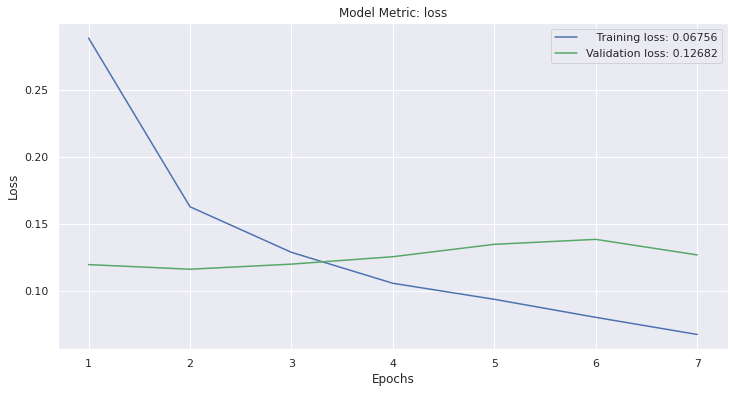

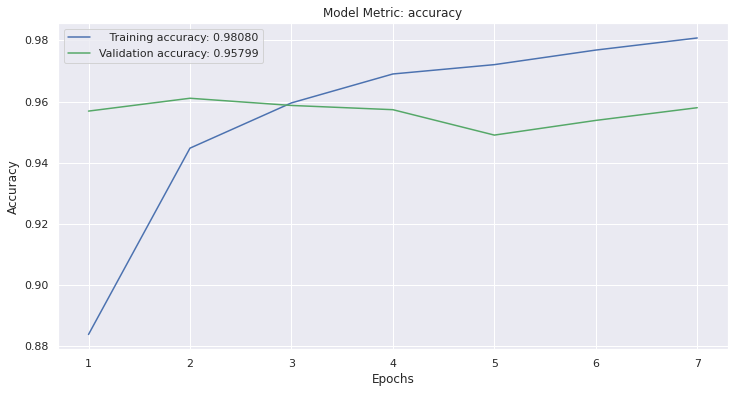

In [ ]:
sns.set()
plot_keras_history(history_lstm_under)

#### Model Prediction

In [ ]:
predicted_under = lstm_under.predict(test_padded) #change val and test
predicted_under = tf.greater(predicted_under, .5)

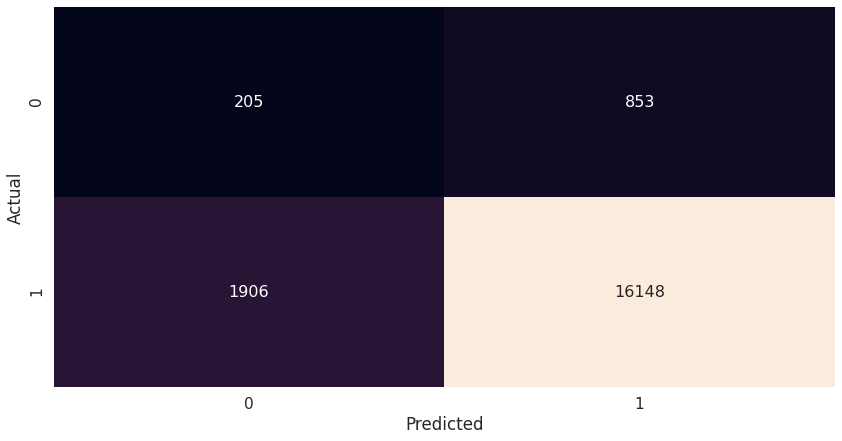

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns

array_final = confusion_matrix(y_test, predicted_under)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

## Logistic Regression Model

### With Imbalanced dataset

In [ ]:
from sklearn.linear_model import LogisticRegression

def log_reg(X_train, y_train, X_test, y_test, _C=1.0):
    model = LogisticRegression(C=_C, penalty='l2', max_iter=100000).fit(X_train, y_train)
    score = model.score(X_test, y_test)
    print('Validation Score is', score)
    return model

#### Fitting (training) and Evaluating our LogReg Model

In [ ]:
log_model = log_reg(X_train_enc_bow, y_train, X_val_enc_bow, y_val)

Validation Score is 0.9620498614958449


#### Model Prediction

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = log_model.predict(X_test_enc_bow)
predicted = np.where(predicted > 0.5, 1, 0)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression AUC:",metrics.roc_auc_score(y_test, predicted))

Logistic Regression Accuracy: 0.9624843030556718
Logistic Regression Precision: 0.9699138071231095
Logistic Regression Recall: 0.9910269192422732
Logistic Regression AUC: 0.7332261250275638


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=predicted))

              precision    recall  f1-score   support

           0       0.76      0.48      0.58      1058
           1       0.97      0.99      0.98     18054

    accuracy                           0.96     19112
   macro avg       0.86      0.73      0.78     19112
weighted avg       0.96      0.96      0.96     19112



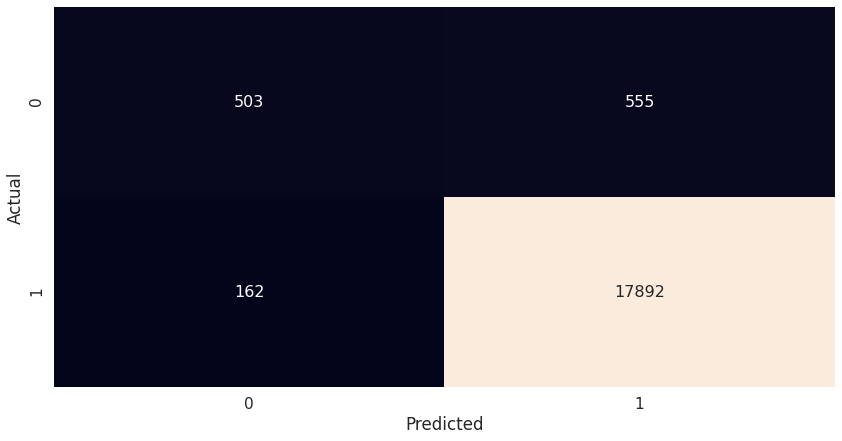

In [ ]:
array_final = confusion_matrix(y_test, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Oversampling

#### Fitting (training) and Evaluating our LogReg Model

In [ ]:
log_model_up = log_reg(X_train_enc_bow_up, upsampled.approved, X_val_enc_bow_up, y_val)

Validation Score is 0.9593721144967683


In [ ]:
upsampled.review

6120                         εαν εχετε χρηματα ολα ενταξει
58840                        έμεινα απολυτα ευχαριστημενος
30628    ευγενικος προθυμος απαντησει ολες αποριες αφιε...
19997                                      οχι εμπιστοσυνη
69014    ην κυρια καρυωτακη συστηνω ανεπιφυλακτα έφυγα ...
                               ...                        
16459    εμπνεει εμπιστοσυνη ασχολειται διεξοδικα ασθεν...
54597    προσεγγισε προσοχη ενδιαφερον εμεινα αρκετα ικ...
7663     φιλοχρηματος πηρε λεφτα κ 2 ραντεβου 10 επισκε...
20339       έμεινα πολυ ευχαρηστημενη συνιστω ανεπιφυλακτα
1369     αναλυτικος επεξηγηματικος διαθεση λυσει καθε α...
Name: review, Length: 102306, dtype: object

#### Model Prediction

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = log_model_up.predict(X_test_enc_bow_up)
predicted = np.where(predicted > 0.5, 1, 0)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression AUC:",metrics.roc_auc_score(y_test, predicted))

Logistic Regression Accuracy: 0.9576182503139389
Logistic Regression Precision: 0.9840556927913766
Logistic Regression Recall: 0.9708651822310845
Logistic Regression AUC: 0.8512170901703626


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=predicted))

              precision    recall  f1-score   support

           0       0.60      0.73      0.66      1058
           1       0.98      0.97      0.98     18054

    accuracy                           0.96     19112
   macro avg       0.79      0.85      0.82     19112
weighted avg       0.96      0.96      0.96     19112



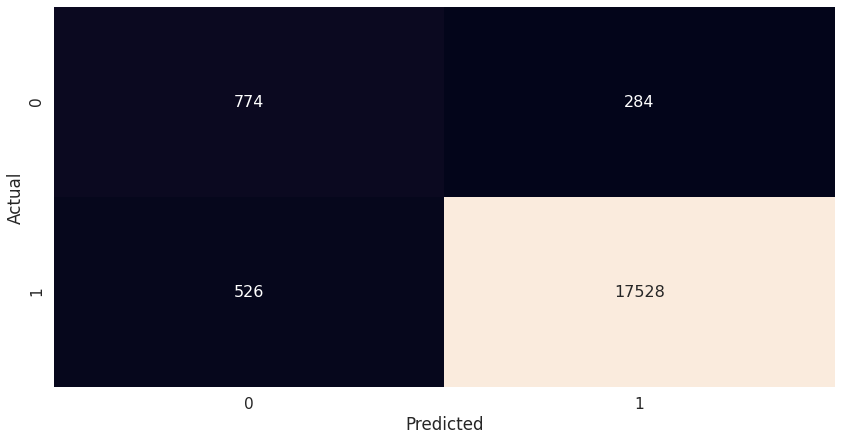

In [ ]:
array_final = confusion_matrix(y_test, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

### Undersampling

#### Fitting (training) our LogReg Model

In [ ]:
log_model_down = log_reg(X_train_enc_bow_down, downsampled.approved, X_val_enc_bow_down, y_val)

Validation Score is 0.9580332409972299


#### Model Prediction

In [ ]:
from sklearn import metrics
# Predicting with a test dataset
predicted = log_model_down.predict(X_test_enc_bow_down)
predicted = np.where(predicted > 0.5, 1, 0)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted))
print("Logistic Regression AUC:",metrics.roc_auc_score(y_test, predicted))

Logistic Regression Accuracy: 0.9586123901213897
Logistic Regression Precision: 0.9817491767595021
Logistic Regression Recall: 0.9742993242494739
Logistic Regression AUC: 0.8326128001209563


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=predicted))

              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1058
           1       0.98      0.97      0.98     18054

    accuracy                           0.96     19112
   macro avg       0.80      0.83      0.81     19112
weighted avg       0.96      0.96      0.96     19112



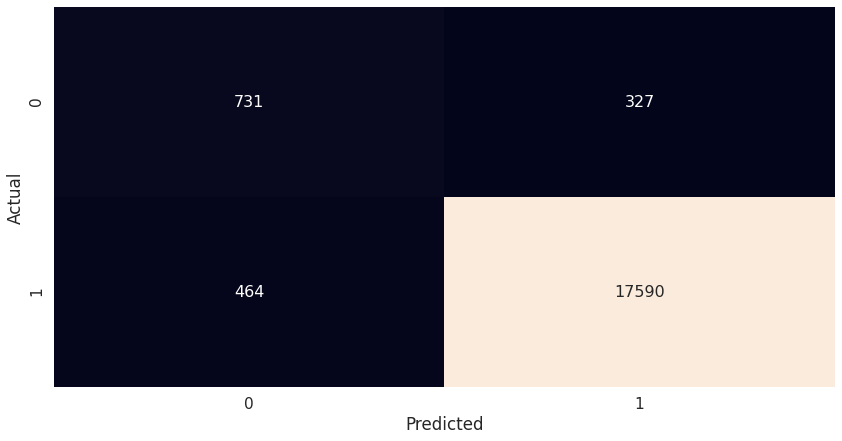

In [ ]:
array_final = confusion_matrix(y_test, predicted)
x_axis = ['0','1']
cm = pd.DataFrame(array_final)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(14,7))

sns.set(font_scale=1.4)
sns.heatmap(cm,xticklabels=x_axis,yticklabels=x_axis, cbar=False, fmt='d',annot=True, annot_kws={"size":16})

## Saving the models

In [ ]:
model

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward')
model_over.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_over')
model_under.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_under')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_over/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_under/assets


In [ ]:
lstm.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm')
lstm_over.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_over')
lstm_under.save('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_under')

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_over/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_under/assets


## Logistic Regression Word Highlighting

In [ ]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(counter_vectorizer, log_model)

In [ ]:
X_test

46752                        προσιτος φιλικος επαγγελματιας
120136                          καλος ιατρος καλος ανθρωπος
76035     πρωτη εντυπωση πολυ θετικη φιλικος προσιτος γι...
120155    παρα πολυ καλος γιατροσεμεινα πολυ ευχαριστημε...
12910                                           εξαιρετικος
                                ...                        
30580     ευγενεστατη προσιτη ανθρωπινη κατανοηση καταρτ...
123275    γιατρος καταπληκτικος εχω μεινει εξαιρετικα ικ...
31598     γιατρος ευγενικη συνεπης εκανε αισθανθω ανετα ...
25988     εξαιρετικη γιατρος ευγενεστατη δεν δημιουργουσ...
114965            προσιτοςδειχνει ενδιαφερον σωστος δουλεια
Name: review, Length: 19112, dtype: object

In [ ]:
print(X_test.iloc[10])

πολυ ευγενικη κυρια κατερινα συνεπης ραντεβου δεν περιμενα καθολου πολυ ελαφρυ χερι οσους φοβουνται δεν πονεσα καθολου καθαρισμο δοντιων εκανε νιωσω ανετα προτεινω ανεπιφυλακτα επισκεφθειτε επισκεφθω σιγουρα μελλον


In [ ]:
print(pipe.predict_proba([X_test.iloc[10]]))

[[0.9556759 0.0443241]]


In [ ]:
pipe.predict_proba([X_test.iloc[10]])

array([[0.9556759, 0.0443241]])

In [ ]:
pipe.predict_proba

<function sklearn.pipeline.Pipeline.predict_proba>

In [ ]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["not approved", "approved"], bow=False)

In [ ]:
X_test

46752                        προσιτος φιλικος επαγγελματιας
120136                          καλος ιατρος καλος ανθρωπος
76035     πρωτη εντυπωση πολυ θετικη φιλικος προσιτος γι...
120155    παρα πολυ καλος γιατροσεμεινα πολυ ευχαριστημε...
12910                                           εξαιρετικος
                                ...                        
30580     ευγενεστατη προσιτη ανθρωπινη κατανοηση καταρτ...
123275    γιατρος καταπληκτικος εχω μεινει εξαιρετικα ικ...
31598     γιατρος ευγενικη συνεπης εκανε αισθανθω ανετα ...
25988     εξαιρετικη γιατρος ευγενεστατη δεν δημιουργουσ...
114965            προσιτοςδειχνει ενδιαφερον σωστος δουλεια
Name: review, Length: 19112, dtype: object

In [ ]:
max_features = X_test.str.split().map(lambda x: len(x)).max()
print(max_features)

624


In [ ]:
import random
#random.seed(13)
idx = random.randint(0, len(X_test))

exp = explainer.explain_instance(X_test.iloc[idx] #normalize("τελειος γιατρος. εξαιρετικη διαγνωση")
    , pipe.predict_proba, num_features=5
)

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


In [ ]:
X_test.iloc[idx] 

'εξαιρετικος γιατρος κερδισε εμπιστοσυνη'

In [ ]:
print(
    f"Probability of the sample to be not approved is: {pipe.predict_proba([X_test.iloc[idx]])[0, 1]}\n"
)
print(f"Explanation as a list of weighted features:")
exp.as_list()

Probability of the sample to be not approved is: 0.7650316425443662

Explanation as a list of weighted features:


[('εξαιρετικος', 0.1241608823184522),
 ('γιατρος', -0.10884501488221784),
 ('εμπιστοσυνη', 0.02373165873443077),
 ('κερδισε', -0.02200307434677805)]

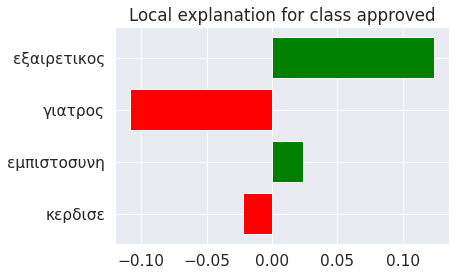

In [ ]:
f = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=True)

## Classification Report for all models

In [ ]:
from keras.models import load_model

model_feed = load_model('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward')
model_feed_over = load_model('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_over')
model_feed_under = load_model('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/feed_forward_under')

In [ ]:
model_lstm = load_model('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm')
model_lstm_over = load_model('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_over')
model_lstm_under = load_model('/content/drive/My Drive/Colab Notebooks/reviews_moderation_v2/data/Greek/tensorflow_saved_models/lstm_under')

### LSTM model predictions

In [ ]:
predicted_lstm = model_lstm.predict(test_padded) #change val and test
predicted_lstm = tf.greater(predicted_lstm, .5)

In [ ]:
predicted_lstm_over = model_lstm_over.predict(test_padded) #change val and test
predicted_lstm_over = tf.greater(predicted_lstm_over, .5)

In [ ]:
predicted_lstm_under = model_lstm_under.predict(test_padded) #change val and test
predicted_lstm_under = tf.greater(predicted_lstm_under, .5)

#### LSTM report - Imbalanced dataset

In [ ]:
import sklearn

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, roc_auc_score

In [ ]:
print("LSTM Imbalanced prec:", sklearn.metrics.precision_score(y_test, predicted_lstm))
print("LSTM Imbalanced recall:",sklearn.metrics.recall_score(y_test, predicted_lstm))
print("LSTM Imbalanced accuracy:",sklearn.metrics.accuracy_score(y_test, predicted_lstm))
print("LSTM Imbalanced auc:",sklearn.metrics.roc_auc_score(y_test, predicted_lstm))

LSTM Imbalanced prec: 0.981768963040716
LSTM Imbalanced recall: 0.9843248033676748
LSTM Imbalanced accuracy: 0.967925910422771
LSTM Imbalanced auc: 0.8362077703038752


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print(classification_report(y_true=y_test,
                            y_pred=predicted_lstm))

              precision    recall  f1-score   support

           0       0.72      0.69      0.70      1058
           1       0.98      0.98      0.98     18054

    accuracy                           0.97     19112
   macro avg       0.85      0.84      0.84     19112
weighted avg       0.97      0.97      0.97     19112



#### LSTM report - Undersampling

In [ ]:
print("LSTM Imbalanced prec:", sklearn.metrics.precision_score(y_test, predicted_lstm_under))
print("LSTM Imbalanced recall:",sklearn.metrics.recall_score(y_test, predicted_lstm_under))
print("LSTM Imbalanced accuracy:",sklearn.metrics.accuracy_score(y_test, predicted_lstm_under))
print("LSTM Imbalanced auc:",sklearn.metrics.roc_auc_score(y_test, predicted_lstm_under))

LSTM Imbalanced prec: 0.9498264807952473
LSTM Imbalanced recall: 0.8944278276282265
LSTM Imbalanced accuracy: 0.8556404353285894
LSTM Imbalanced auc: 0.544094821186514


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=predicted_lstm_under))

              precision    recall  f1-score   support

           0       0.10      0.19      0.13      1058
           1       0.95      0.89      0.92     18054

    accuracy                           0.86     19112
   macro avg       0.52      0.54      0.53     19112
weighted avg       0.90      0.86      0.88     19112



#### LSTM report - Oversampling

In [ ]:
print("LSTM Imbalanced prec:", sklearn.metrics.precision_score(y_test, predicted_lstm_over))
print("LSTM Imbalanced recall:",sklearn.metrics.recall_score(y_test, predicted_lstm_over))
print("LSTM Imbalanced accuracy:",sklearn.metrics.accuracy_score(y_test, predicted_lstm_over))
print("LSTM Imbalanced auc:",sklearn.metrics.roc_auc_score(y_test, predicted_lstm_over))

LSTM Imbalanced prec: 0.9503970755073743
LSTM Imbalanced recall: 0.835216572504708
LSTM Imbalanced accuracy: 0.8031603181247384
LSTM Imbalanced auc: 0.5456801199007472


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=predicted_lstm_over))

              precision    recall  f1-score   support

           0       0.08      0.26      0.13      1058
           1       0.95      0.84      0.89     18054

    accuracy                           0.80     19112
   macro avg       0.52      0.55      0.51     19112
weighted avg       0.90      0.80      0.85     19112



In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=predicted_lstm_over)
conf_mat

array([[  271,   787],
       [ 2975, 15079]])

### Feed_forward model predictions

In [ ]:
predicted_feed = model_feed.predict(X_test_enc_bow)
predicted_feed = tf.greater(predicted_feed, .5)
predicted_feed.numpy()

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
predicted_feed_over = model_feed_over.predict(X_test_enc_bow_up)
predicted_feed_over = tf.greater(predicted_feed_over, .5)
predicted_feed_over.numpy()

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
predicted_feed_under = model_feed_under.predict(X_test_enc_bow_down)
predicted_feed_under = tf.greater(predicted_feed_under, .5)
predicted_feed_under.numpy()

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [False],
       [ True]])

#### Feed forward report - Imbalanced dataset

In [ ]:
print("LSTM Imbalanced prec:", sklearn.metrics.precision_score(y_test, predicted_feed.numpy()))
print("LSTM Imbalanced recall:",sklearn.metrics.recall_score(y_test, predicted_feed.numpy()))
print("LSTM Imbalanced accuracy:",sklearn.metrics.accuracy_score(y_test, predicted_feed.numpy()))
print("LSTM Imbalanced auc:",sklearn.metrics.roc_auc_score(y_test, predicted_feed.numpy()))

LSTM Imbalanced prec: 0.984156880124086
LSTM Imbalanced recall: 0.9840478564307079
LSTM Imbalanced accuracy: 0.9699665131854333
LSTM Imbalanced auc: 0.8568632476860534


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=predicted_feed))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1058
           1       0.98      0.98      0.98     18054

    accuracy                           0.97     19112
   macro avg       0.86      0.86      0.86     19112
weighted avg       0.97      0.97      0.97     19112



In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=predicted_feed)
conf_mat

array([[  772,   286],
       [  288, 17766]])

#### Feed_forward Undersampling

In [ ]:
print("LSTM Imbalanced prec:", sklearn.metrics.precision_score(y_test, predicted_feed_under.numpy()))
print("LSTM Imbalanced recall:",sklearn.metrics.recall_score(y_test, predicted_feed_under.numpy()))
print("LSTM Imbalanced accuracy:",sklearn.metrics.accuracy_score(y_test, predicted_feed_under.numpy()))
print("LSTM Imbalanced auc:",sklearn.metrics.roc_auc_score(y_test, predicted_feed_under.numpy()))

LSTM Imbalanced prec: 0.9890314920563126
LSTM Imbalanced recall: 0.9689265536723164
LSTM Imbalanced accuracy: 0.9604960234407702
LSTM Imbalanced auc: 0.8927808571764229


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=predicted_feed_under))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70      1058
           1       0.99      0.97      0.98     18054

    accuracy                           0.96     19112
   macro avg       0.80      0.89      0.84     19112
weighted avg       0.97      0.96      0.96     19112



In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=predicted_feed_under)
conf_mat

array([[  864,   194],
       [  561, 17493]])

#### Feed_forward Oversampling

In [ ]:
print("LSTM Imbalanced prec:", sklearn.metrics.precision_score(y_test, predicted_feed_over.numpy()))
print("LSTM Imbalanced recall:",sklearn.metrics.recall_score(y_test, predicted_feed_over.numpy()))
print("LSTM Imbalanced accuracy:",sklearn.metrics.accuracy_score(y_test, predicted_feed_over.numpy()))
print("LSTM Imbalanced auc:",sklearn.metrics.roc_auc_score(y_test, predicted_feed_over.numpy()))

LSTM Imbalanced prec: 0.9817338998951493
LSTM Imbalanced recall: 0.9853772017281489
LSTM Imbalanced accuracy: 0.9688677270824613
LSTM Imbalanced auc: 0.8362613796920518


In [ ]:
print(classification_report(y_true=y_test,
                            y_pred=predicted_feed_over))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1058
           1       0.98      0.99      0.98     18054

    accuracy                           0.97     19112
   macro avg       0.86      0.84      0.85     19112
weighted avg       0.97      0.97      0.97     19112



In [ ]:
conf_mat = confusion_matrix(y_true=y_test,
                            y_pred=predicted_feed_over)
conf_mat

array([[  727,   331],
       [  264, 17790]])